In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data1917


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [3]:
import zipfile
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt
import matplotlib.image as mping
from PIL import Image
import json
import numpy as np
import cv2
import sys
import time
import h5py
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from matplotlib import cm as CM
from paddle.utils.plot import Ploter
import os

In [4]:
# 解压文件
if(not os.path.isdir("train")):     
        z = zipfile.ZipFile("data/data1917/train_new.zip", 'r')
        z.extractall("")
        z.close()
start = time.time()

In [5]:
# 把图片对应的标签装入字典
f = open('/home/aistudio/data/data1917/train.json',encoding='utf-8')
content = json.load(f)

In [6]:
# 数据处理
need_data = []
for j in range(len(content['annotations'])):
    if content['annotations'][j]['num'] <= 20:
        need_data.append(content['annotations'][j])
for j in range(len(need_data)):
    need_data[j]['name'] = need_data[j]['name'].lstrip('stage1').lstrip('/')
# 将数据分为测试集和训练集
train_data = []
test_data = []
for j in range(len(need_data)):
    if j % 10 == 0:
        test_data.append(need_data[j])
    else:
        train_data.append(need_data[j])

In [7]:
def gaussian_filter_density(gt):
    #Generates a density map using Gaussian filter transformation
    
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    
    # if gt_count > 0 and gt_count < 20: 
    
    # leafsize = 2048

    # # build kdtree
    # tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    # distances, locations = tree.query(pts, k=4)
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            # sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
            sigma = 25
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')

    return density


In [8]:
#图片操作
def picture_opt(img,ann):
    size_x,size_y = img.size
    train_img_size = (640,480)
    img = img.resize(train_img_size,Image.ANTIALIAS)
    img = np.array(img)                  
    img = img / 255.0

    gt = []
    for b_l in range(len(ann)):                             
        if 'w' in ann[b_l].keys(): 
            x = (ann[b_l]['x']+(ann[b_l]['x']+ann[b_l]['w']))/2
            y = ann[b_l]['y']+20
            x = (x*640/size_x)/8
            y = (y*480/size_y)/8
            gt.append((x,y))   
        else:
            x = ann[b_l]['x']
            y = ann[b_l]['y']
            x = (x*640/size_x)/8
            y = (y*480/size_y)/8
            gt.append((x,y)) 

    return img,gt


In [9]:
#密度图处理
def ground(img,gt):
    imgs = img
    x = imgs.shape[0]/8
    y = imgs.shape[1]/8
    k = np.zeros((int(x),int(y)))

    for i in range(0,len(gt)):
        if int(gt[i][1]) < int(x) and int(gt[i][0]) < int(y):
            k[int(gt[i][1]),int(gt[i][0])]=1

    k = gaussian_filter_density(k)
    return k

In [10]:
def train_r():
    def reader():
        for index in range(len(train_data)):
            #把忽略区域都用像素为0填上
            if train_data[index]['ignore_region']:
                if len(train_data[index]['ignore_region'])==2:
                    continue
                if len(train_data[index]['ignore_region'])==1:
                    ig_list = []  
                    ign_rge = train_data[index]['ignore_region'][0]
                    for ig_len in range(len(ign_rge)):
                        ig_list.append([ign_rge[ig_len]['x'],ign_rge[ig_len]['y']])
                    ig_cv_img = cv2.imread(train_data[index]['name'])
                    pts = np.array(ig_list,np.int32)
                    cv2.fillPoly(ig_cv_img,[pts],(0,0,0),cv2.LINE_AA)
                    ig_img = Image.fromarray(cv2.cvtColor(ig_cv_img,cv2.COLOR_BGR2RGB))
                    ann = train_data[index]['annotation']                   
                    ig_im,gt = picture_opt(ig_img,ann)
                    k = ground(ig_im,gt)
                    groundtruth = np.asarray(k)
                    groundtruth = groundtruth.T.astype('float32')
                    ig_im = ig_im.transpose().astype('float32')
                    yield ig_im,groundtruth
            else:
                img = Image.open(train_data[index]['name'])
                ann = train_data[index]['annotation']
                im,gt = picture_opt(img,ann)
                k = ground(im,gt)
                groundtruth = np.asarray(k)
                groundtruth = groundtruth.T.astype('float32')
                im = im.transpose().astype('float32')
                yield im,groundtruth
    return reader

In [11]:
def CVPR_15(img):
    # 网络一
    x = fluid.layers.conv2d(input=img, num_filters=64, filter_size=3, padding=1, act='relu')
    x = fluid.layers.conv2d(input=x, num_filters=64, filter_size=3, padding=1, act='relu')  
    x = fluid.layers.pool2d(input=x, pool_size=2, pool_stride=2, pool_type='max')  

    x = fluid.layers.conv2d(input=x, num_filters=128, filter_size=3, padding=1, act='relu')  
    x = fluid.layers.conv2d(input=x, num_filters=128, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.pool2d(input=x, pool_size=2, pool_stride=2, pool_type='max')
    
    x = fluid.layers.conv2d(input=x, num_filters=256, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=256, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=256, filter_size=3, padding=1, act='relu')  
    x = fluid.layers.pool2d(input=x, pool_size=2, pool_stride=2, pool_type='max')

    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1)
    x = fluid.layers.pool2d(input=x, pool_size=3, pool_stride=3, pool_type='max')

    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1)

    # 网络二
    y = fluid.layers.conv2d(input=img, num_filters=24, filter_size=5, padding=1, act='relu')
    y = fluid.layers.pool2d(input=y, pool_size=5, pool_stride=5, pool_type='avg')

    y = fluid.layers.conv2d(input=y, num_filters=24, filter_size=5, padding=1, act='relu')
    y = fluid.layers.pool2d(input=y, pool_size=5, pool_stride=5, pool_type='avg')

    y = fluid.layers.conv2d(input=y, num_filters=24, filter_size=5, padding=1, act='relu')
    y = fluid.layers.pool2d(input=y, pool_size=5, pool_stride=5, pool_type='avg')

    # 特征融合
    output = fluid.layers.concat(input=[x,y], axis=0)
    output = fluid.layers.conv2d(input=output, num_filters=1, filter_size=1, act=None)
    return output


In [12]:
def CSRnet(img):
    # front-end
    x = fluid.layers.conv2d(input=img, num_filters=64, filter_size=3, padding=1, act='relu')
    x = fluid.layers.conv2d(input=x, num_filters=64, filter_size=3, padding=1, act='relu')  
    x = fluid.layers.pool2d(input=x, pool_size=2, pool_stride=2, pool_type='max')  

    x = fluid.layers.conv2d(input=x, num_filters=128, filter_size=3, padding=1, act='relu')  
    x = fluid.layers.conv2d(input=x, num_filters=128, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.pool2d(input=x, pool_size=2, pool_stride=2, pool_type='max')
    
    x = fluid.layers.conv2d(input=x, num_filters=256, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=256, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=256, filter_size=3, padding=1, act='relu')  
    x = fluid.layers.pool2d(input=x, pool_size=2, pool_stride=2, pool_type='max')

    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1)  

    # back-end
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, dilation=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, dilation=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=512, filter_size=3, padding=1, dilation=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=256, filter_size=3, padding=1, dilation=1, act='relu')
    x = fluid.layers.conv2d(input=x, num_filters=128, filter_size=3, padding=1, dilation=1, act='relu') 
    x = fluid.layers.conv2d(input=x, num_filters=64, filter_size=3, padding=1, dilation=1, act='relu')
    
    output = fluid.layers.conv2d(input=x, num_filters=1, filter_size=1, act=None) 
    print(output.shape)
    return output

In [13]:
images = fluid.layers.data(name='images',shape=[3,640,480],dtype='float32')
label = fluid.layers.data(name='label',shape=[1,80,60],dtype='float32')
net = CSRnet(images)

(-1, 1, 80, 60)


In [14]:
squar = fluid.layers.square_error_cost(input=net, label=label)
cost = fluid.layers.sqrt(squar, name=None)
avg_cost = fluid.layers.mean(cost)

In [15]:
# 创建优化器optimizer，下面列举了2种常用的优化器，不同类型优化器选一即可
# 创建Momentum优化器，并设置学习率(learning_rate)、动量(momentum)
# optimizer = fluid.optimizer.Momentum(
#     learning_rate=0.001,
#     momentum=0.8)
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=1e-6)# 1e-6
# optimizer = fluid.optimizer.SGD(learning_rate=1e-5)
opt = optimizer.minimize(avg_cost)

In [16]:
# 创建执行器
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place=place)
exe.run(program=fluid.default_startup_program())

[]

In [17]:
# 设置训练reader
BUF_SIZE = 50 # 缓存的数量
BATCH_SIZE= 20 # 每次得到的图片数量为BUF_SIZE/BATCH_SIZE
train_reader = paddle.batch(reader=paddle.reader.shuffle(reader=train_r(), buf_size=BUF_SIZE), batch_size=BATCH_SIZE)

In [18]:
# 定义输入数据的维度
feeder = fluid.DataFeeder(feed_list=[images, label],place=place)
#训练保存
model_save_dir = 'model'

In [19]:
train_prompt = "Train cost"
cost_ploter = Ploter(train_prompt)
def event_handler_plot(ploter_title, step, cost):
    cost_ploter.append(ploter_title, step, cost)
    cost_ploter.plot()

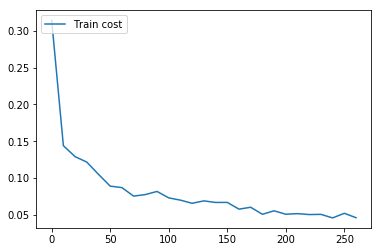

[-30.47263, 26.574163, 19.89978, -8.452182, -95.25432, -20.330183, 64.27954, -87.1494, 28.29589, 46.90323, 28.37881, -61.38383, -54.340546, 70.99138, 52.369774, -0.9055729, -94.35422, -34.456104, -120.19591, -34.33035] [6.640066, 2.9177027, 1.6523756, 3.5643258, 10.630569, 6.410203, 2.305056, 7.697255, 0.7099135, 5.9921017, 4.371376, 6.115739, 6.2392426, 9.059931, 1.1422112, 8.857534, 4.171547, 6.839027, 5.8821964, 6.1664467] -303.93268 107.364815
Pass:0, Batch:10, Cost:0.14405
[143.58485, 150.73677, 110.214584, 86.71442, 108.91911, 169.87097, 155.83533, 156.93549, 211.0217, 182.79808, 180.80682, 121.635574, 147.23334, 167.80606, 194.43063, 128.90022, 195.9967, 155.76921, 128.43689, 124.8302] [3.2026992, 8.900888, 6.1544075, 6.79438, 1.1615486, 6.4451017, 4.9700055, 5.7612104, 6.2568245, 3.9614086, 2.1611505, 10.4135475, 1.6742449, 2.1815052, 3.5811744, 6.425334, 7.7737217, 7.9830523, 8.15143, 7.8613353] 3022.4768 111.81497
Pass:0, Batch:20, Cost:0.12911
[-27.722927, -54.42668, -60.608

<Figure size 432x288 with 0 Axes>

In [20]:
# 开始训练
lists = []
step = 0
for pass_id in range(5):
    # 开始训练
    for batch_id, batch_data in enumerate(train_reader()):
        train_cost,sult,lab = exe.run(program=fluid.default_main_program(),
                             feed=feeder.feed(batch_data),
                             fetch_list=[avg_cost,net,label])
        if step % 10 == 0:
            event_handler_plot(train_prompt,step,train_cost[0])
        if batch_id % 10 == 0:
            p = [np.sum(pre) for pre in sult]
            l = [np.sum(pre) for pre in lab]
            print(p,l,np.sum(sult),np.sum(lab))
            print('Pass:%d, Batch:%d, Cost:%0.5f' % (pass_id, batch_id, train_cost[0]))
        step += 1
    
    # 保存模型
    if model_save_dir is not None:
        fluid.io.save_inference_model(model_save_dir, ['images'], [net], exe)

print('训练模型保存完成！')
end = time.time()
print(time.strftime('V100训练用时：%M分%S秒',time.localtime(end-start)))

In [23]:
use = True
place1 = fluid.CUDAPlace(0) if use else fluid.CPUPlace()
infer_exe = fluid.Executor(place1)

inference_scope = fluid.core.Scope()  

model_save_dir = 'model'

ans = []
with fluid.scope_guard(inference_scope):
    [inference_program,                          
     feed_target_names,                           
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,infer_exe)      

    for index in range(len(test_data)):
        test_img = Image.open(test_data[index]['name'])
        test_img = test_img.resize((640,480),Image.ANTIALIAS)
        test_im = np.array(test_img)
        test_im = test_im / 255.0
        test_im = test_im.transpose().reshape(1,3,640,480).astype('float32')

        result = infer_exe.run(inference_program,
                            feed={feed_target_names[0]: test_im},
                            fetch_list=fetch_targets)
    
        people = abs(np.sum(result))
        ans.append(people)
    print(len(test_data))
    print(len(ans))
    cost_sum = 0
    acc = 0
    for i in range(len(test_data)):
        if int(test_data[i]['num']) == int(ans[i]):
            acc = acc + 1
        print(test_data[i]['num'], ans[i])
        cost_sum = cost_sum + abs(test_data[i]['num']-ans[i])
    print('cost:', cost_sum/len(test_data))
    print('acc:', acc/len(test_data))


119
119
11 0.94709563
14 7.56851
20 11.353598
18 19.495588
5 9.233294
10 10.30814
5 2.8681846
7 5.083844
17 6.928925
10 6.85556
5 3.1358762
15 0.5170841
5 3.814872
8 5.9141145
5 2.8065124
19 13.105983
18 1.3014221
8 7.8636575
5 0.40443373
7 6.014054
12 15.789986
7 5.619818
6 6.383151
17 1.7324109
12 13.156896
8 3.5020473
6 6.1726274
9 5.411644
5 3.7414794
11 4.822648
19 4.2549143
10 0.8963356
14 7.6713142
8 9.947928
8 5.783479
10 2.3881407
10 21.616467
10 0.93448114
7 7.32695
12 4.2741375
5 1.9489528
15 13.093082
10 2.5345345
4 5.749097
10 7.4402685
20 19.008457
9 9.829737
20 0.15596604
10 6.897939
5 4.752079
7 0.63099587
6 1.4687413
14 12.647503
6 5.444378
7 2.07972
6 2.6917105
7 0.36872888
5 5.5002313
18 8.984569
13 2.9928358
4 4.3154755
12 10.963528
3 10.592214
5 5.204744
13 1.3505814
5 4.3149858
4 14.991837
4 4.967469
5 3.060967
8 2.6657054
5 8.505264
11 23.862988
18 0.9760499
4 9.77466
5 0.7176082
13 8.3539095
6 2.0592573
2 7.082823
7 0.40094995
15 13.480228
6 1.6951964
5 3.533988